# Extract CSV files from Yearly XML Gas Prices

See https://www.prix-carburants.gouv.fr/rubrique/opendata/


In [1]:
import argparse
import sys
import zipfile
import os.path

from xml.etree import cElementTree


def generate_prices(filename, header=False):
    """Generate prices to csv file from XML"""

    if header:
        print(';'.join(['id', 'cp', 'pop', 'lat', 'long', 'date', 'type', 'name', 'prix']))
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename) as zfile:
            file = zfile.open(zfile.namelist()[0])
    else:
        file = filename

    tree = cElementTree.parse(file)
    pdvs = tree.getroot()
    for pdv in pdvs:
        id_pdv = pdv.attrib['id']
        pop = pdv.attrib['pop']
        lat = pdv.attrib['latitude']
        lon = pdv.attrib['longitude']
        cp_pdv = pdv.attrib['cp']
        for prix in pdv.iter('prix'):
            date = prix.attrib['maj'] if 'maj' in prix.keys() else ''
            id_prix = prix.attrib['id'] if 'id' in prix.keys() else ''
            valeur = prix.attrib['valeur'] if 'valeur' in prix.keys() else ''
            nom = prix.attrib['nom'] if 'nom' in prix.keys() else ''
            row = ';'.join([id_pdv, cp_pdv, pop, lat, lon, date, id_prix, nom, valeur])
            print(row)
    if filename.endswith('.zip'):
        file.close()
        zfile.close()
    return


def generate_stations(filename, header=False):
    """Generate stations (pdv) to csv file from XML"""

    if header:
        print(';'.join(['id', 'cp', 'pop', 'lat', 'long', 'date', 'type', 'name', 'prix']))
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename) as zfile:
            file = zfile.open(zfile.namelist()[0])
    else:
        file = filename

    tree = cElementTree.parse(file)
    pdvs = tree.getroot()
    for pdv in pdvs:
        id_pdv = pdv.attrib['id']
        pop = pdv.attrib['pop']
        lat = pdv.attrib['latitude']
        lon = pdv.attrib['longitude']
        adresse = pdv.find('adresse').text
        if adresse is None:
            adresse = ''
        ville = pdv.find('ville').text
        if ville is None:
            ville = ''
        cp_pdv = pdv.attrib['cp']
        row = '|'.join([id_pdv, cp_pdv, pop, lat, lon, adresse, ville])
        print(row)
    if filename.endswith('.zip'):
        file.close()
        zfile.close()
    return


def generate_services(filename, header=False):
    """Generate services to csv file from XML"""

    if header:
        print(';'.join(['id', 'cp', 'pop', 'lat', 'long', 'services']))
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename) as zfile:
            file = zfile.open(zfile.namelist()[0])
    else:
        file = filename

    tree = cElementTree.parse(file)
    pdvs = tree.getroot()
    for pdv in pdvs:
        id_pdv = pdv.attrib['id']
        pop = pdv.attrib['pop']
        lat = pdv.attrib['latitude']
        lon = pdv.attrib['longitude']
        cp_pdv = pdv.attrib['cp']
        services = ','.join([service.text for service in pdv.iter('service')])
        row = '|'.join([id_pdv, cp_pdv, pop, lat, lon, services])
        print(row)
    if filename.endswith('.zip'):
        file.close()
        zfile.close()
    return

In [2]:
def output_to_file(source_file, destination_file, extract_type):
  original_stdout = sys.stdout # Save a reference to the original standard output
  try:
    with open(destination_file, 'w') as f:
      sys.stdout = f
      if extract_type == 'prices':
        generate_prices(source_file)
      elif extract_type == 'stations':
        generate_stations(source_file)
      elif extract_type == 'services':
        generate_services(source_file)
      else:
        raise ValueError('Unknown extraction type: {}'.format(extract_type))
        sys.stdout = original_stdout
  finally:
    sys.stdout = original_stdout
  return

In [4]:
output_to_file('PrixCarburants_annuel_2022.zip', 'Prix2022.csv', 'prices')
output_to_file('PrixCarburants_annuel_2022.zip', 'Stations2022.csv', 'stations')
output_to_file('PrixCarburants_annuel_2022.zip', 'Services2022.csv', 'services')

## Compress Files

In [5]:
!gzip Prix2022.csv
!gzip Stations2022.csv
!gzip Services2022.csv

## Split and Compress Prices Files

Prices files can be larger than the 25M limit of Github.

The following instructions split price file in S1 and S2 files.

In [6]:
!zcat Prix2022.csv.gz | grep "2022-0[1-6]" > Prix2022S1.csv
!zcat Prix2022.csv.gz | grep -v "2022-0[1-6]" > Prix2022S2.csv
!gzip Prix2022S1.csv
!gzip Prix2022S2.csv

In [7]:
!ls -lh

total 92M
-rw-r--r-- 1 root root  30M Dec 23 17:06 Prix2022.csv.gz
-rw-r--r-- 1 root root  16M Dec 23 17:08 Prix2022S1.csv.gz
-rw-r--r-- 1 root root  14M Dec 23 17:08 Prix2022S2.csv.gz
-rw-r--r-- 1 root root  33M Dec 23 17:04 PrixCarburants_annuel_2022.zip
drwxr-xr-x 1 root root 4.0K Dec 20 20:19 sample_data
-rw-r--r-- 1 root root 246K Dec 23 17:07 Services2022.csv.gz
-rw-r--r-- 1 root root 347K Dec 23 17:07 Stations2022.csv.gz


## Visual Check

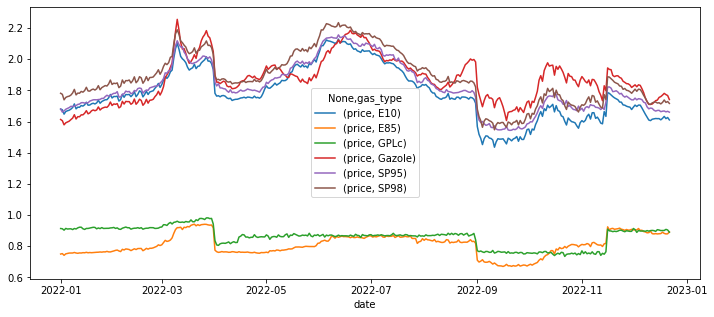

In [16]:
import pandas as pd

(pd.read_csv('Prix2022.csv.gz', sep=';', header=None, parse_dates=[5])
  .rename(columns={5: 'date', 7: 'gas_type', 8: 'price'})
  .assign(date=lambda _df: _df['date'].dt.date)
  [['date', 'gas_type', 'price']]
 .groupby(['date', 'gas_type'])
 .agg({'price': 'mean'})
 .unstack(level=1)
 #.pivot(index='date', columns='gas_type', values='price')
).plot(figsize=(12, 5));